In [4]:
from ugot import ugot
got = ugot.UGOT()
got.initialize('192.168.1.204')
print("Connected")

192.168.1.204:50051
Connected


In [5]:
import time
import numpy as np
import cv2
from IPython.display import display, clear_output
from PIL import Image

# ============== Movement ==============
 
def forward(L_w, R_w):
    got.turn_motor_speed(31, R_w)
    got.turn_motor_speed(41, -L_w)
 
def left(L_w, R_w):
    got.turn_motor_speed(31, R_w)
    got.turn_motor_speed(41, L_w)
 
def right(L_w, R_w):
    got.turn_motor_speed(31, -R_w)
    got.turn_motor_speed(41, -L_w)
 
def stop():
    got.stop_all_servos()
 
# ============== Line Follow ==============
 
def line_following(mult=0.18, speed=25):
    info = got.get_single_track_total_info()
    offset = info[0]
    line_type = info[1]
    rot = round(mult * offset)
 
    if offset > 10:
        left(-speed, rot + speed)
    elif offset < 10:
        right(abs(rot) + speed, -speed)
    else:
        forward(speed, speed)
 
    return line_type
 
# ============== Maze ==============

def maze(target_dist=10, base_speed=25, mult=1.0, turn_time=0.8, min_size=4000):
    while True:

        # COLOR CHECK
        color, side = color_rec(min=min_size)
        if color == "yellow":
            stop()
            print("Yellow detected — stopping.")
            return color, side
        elif color == "red":
            stop()
            print("Red detected — stopping.")
            return color, side

        # Read sensors
        R_dist = got.read_distance_data(21)
        F_dist = got.read_distance_data(22)
        L_dist = got.read_distance_data(23)

        # Stop if front is blocked
        if F_dist < 13:
            break

        # Right hand rule
        # error > 0 - too far from wall (need to turn right)
        # error < 0 - too close to wall (need to turn left)
        error = R_dist - target_dist

        turn = mult * error

        # Steering
        left_speed = base_speed + turn
        right_speed = base_speed - turn

        # Clamp speeds
        left_speed = max(0, min(50, int(left_speed)))
        right_speed = max(0, min(50, int(right_speed)))

        forward(left_speed, right_speed)

    R_dist = got.read_distance_data(21)
    F_dist = got.read_distance_data(22)
    L_dist = got.read_distance_data(23)

    if R_dist > 20:
        right(base_speed, base_speed)
        time.sleep(turn_time)
        stop()
    elif L_dist > 20:
        left(base_speed, base_speed)
        time.sleep(turn_time)
        stop()
    else:
        right(base_speed, base_speed)
        time.sleep(turn_time * 2)
        stop()

# ============== Color Rec ==============
 
# Helper function to find the biggest contour
def biggest_contour(mask, min_area=1500):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None
    # filter by area to reduce noise
    contours = [c for c in contours if cv2.contourArea(c) >= min_area]
    if not contours:
        return None
    return max(contours, key=cv2.contourArea)
 
COLOR_RANGES = {
    'red' : [(np.array([0, 120, 70]), np.array([10, 255, 255])), 
             (np.array([170, 120, 70]), np.array([179, 255, 255]))],
    'blue' : [(np.array([90, 80, 80]), np.array([130, 255, 255]))],
    'yellow' : [(np.array([20, 100, 100]), np.array([30, 255, 255]))],
    'green' : [(np.array([36, 100, 100]), np.array([86, 255, 255]))]
}
 
KERNEL = np.ones((5, 5), np.uint8)
    
def color_rec(min=5000):
    frame = got.read_camera_data()
    if frame is not None:
        nparr = np.frombuffer(frame, np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

        blurred = cv2.GaussianBlur(img, (5, 5), 0)
        hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)

        best_name = None
        best_cnt = None
        best_area = 0
        best_bbox = None
        best_side = None

        for name, ranges in COLOR_RANGES.items():
            mask = np.zeros(hsv.shape[:2], dtype=np.uint8)
            for lo, hi in ranges:
                mask = cv2.bitwise_or(mask, cv2.inRange(hsv, lo, hi))

            mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, KERNEL, iterations=1)
            mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, KERNEL, iterations=1)

            cnt = biggest_contour(mask, min_area=min)
            if cnt is not None:
                area = cv2.contourArea(cnt)
                x, y, w, h = cv2.boundingRect(cnt)

                if area > best_area:
                    best_area = area
                    best_cnt = cnt
                    best_name = name
                    best_bbox = (x, y, w, h)

                    cx = x + w // 2
                    width = img.shape[1]
                    if cx < width * 0.33:
                        best_side = "left"
                    elif cx > width * 0.66:
                        best_side = "right"
                    else:
                        best_side = "front"

                if name == best_name:
                    label = f"{name}: {int(area)} ({best_side})"
                else:
                    label = f"{name}: {int(area)}"

                cv2.rectangle(img, (x, y), (x + w, y + h), (255, 255, 255), 2)
                cv2.putText(img, label, (x, y - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_pil = Image.fromarray(img_rgb)
        clear_output(wait=True)
        display(img_pil)

        return best_name, best_side


 
# ============== Arm Control ==============
def raised_up(ms=2000):
    got.turn_servo_angle(11, 90, ms, wait=False)
    got.turn_servo_angle(12, -120, ms, wait=False)
    got.turn_servo_angle(13, 80, ms, wait=False)
    time.sleep(ms / 1000 + 0.1)
 
def put_down(ms=2000):
    got.turn_servo_angle(11, 90, ms, wait=False)
    got.turn_servo_angle(12, -85, ms, wait=False)
    got.turn_servo_angle(13, -12, ms, wait=False)
    time.sleep(ms / 1000 + 0.1)

def back(ms=2000):
    got.turn_servo_angle(11, -90, ms, wait=False)
    got.turn_servo_angle(12, -165, ms, wait=False)
    got.turn_servo_angle(13, 80, ms, wait=False)
    time.sleep(ms / 1000 + 0.1)

In [ ]:
got.open_camera()

def ball_collect(target_dist=10, base_speed=30, mult=1.0, turn_time=0.8):
    forward(30, 30)
    time.sleep(2)
    right(30, 30)
    time.sleep(0.8)
    forward(30, 30)
    time.sleep(2)
    stop()
    raised_up()

    while True:
        # COLOR CHECK
        color, _ = color_rec(min=15000)
        
        R_dist = got.read_distance_data(21)
        F_dist = got.read_distance_data(22)

        # Right hand rule
        error = R_dist - target_dist

        turn = mult * error

        # Steering
        left_speed = base_speed + turn
        right_speed = base_speed - turn

        # Clamp speeds
        left_speed = max(0, min(50, int(left_speed)))
        right_speed = max(0, min(50, int(right_speed)))

        forward(left_speed, right_speed)

        if color == "red" and F_dist > 30:
            stop()
            put_down()
            time.sleep(1)
            raised_up()

        if F_dist < 18:
            left(base_speed, base_speed)
            time.sleep(turn_time)
            stop()
        
        if R_dist > 40:
            forward(25, 25)
            time.sleep(1.5)
            right(25, 25)
            time.sleep(0.8)
            forward(25, 25)
            time.sleep(4)
            stop()
            return

    
# try:
#     ball_collect()
# except KeyboardInterrupt:
#     stop()

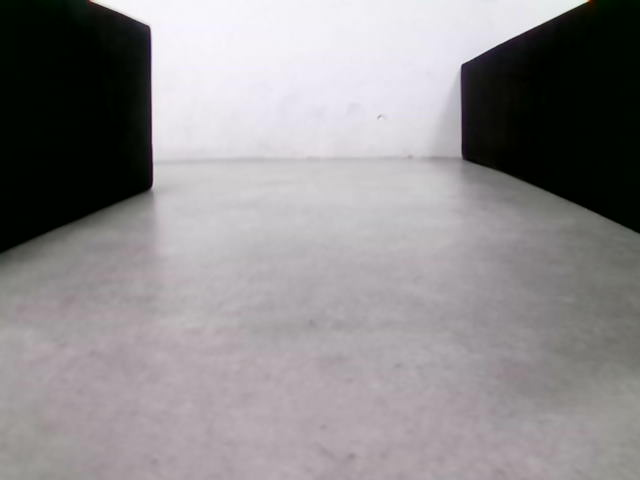

TypeError: cannot unpack non-iterable NoneType object

In [6]:
# Setup
got.load_models(["line_recognition"])
got.set_track_recognition_line(0)
got.open_camera()

try:
    # Line following
    back()
    while True:
        line = line_following(mult=0.19, speed=40)

        if line == 0:
            R_dist = got.read_distance_data(21)
            L_dist = got.read_distance_data(23)
            if R_dist < 20 or L_dist < 20:
                stop()
                break

    # Maze solving
    while True:
        color, side = maze(target_dist=10, base_speed=30, mult=1.0, turn_time=0.8, min_size=4000)
        if color in ("red", "yellow"):
            stop()
            if side == "right":
                right(30, 30)
                time.sleep(0.8)
            elif side == "left":
                left(30, 30)
                time.sleep(0.8)
            elif side == "front":
                forward(30, 30)
                time.sleep(0.8)

            stop()
            break

    # ball collect
    ball_collect()

    print("Finished!")

        
except KeyboardInterrupt:
    stop()
    print("Done")


In [ ]:
stop()

In [55]:
got.load_models(["line_recognition"])
got.set_track_recognition_line(0)
got.open_camera()

try:
    # Maze solving
    while True:
        color, side = color_rec(min=4000)
        print(color)
except KeyboardInterrupt:
    stop()
    print("Done")


Done
